## 1.Import Libraries

In [14]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

## 2.Display Settings

In [8]:
pd.set_option("display.max_columns",None)

In [4]:
sklearn.set_config(transform_output="pandas") # to get output as pandas dataframe 

In [6]:
warnings.filterwarnings("ignore")

## 3. Read the Data

In [9]:
file_path=r"/Users/akashjaiswal/Downloads/flight_project/data/train.csv"
train=pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-05-03,Banglore,Delhi,10:10:00,13:00:00,170,0.0,No Info,3943
1,Jet Airways,2019-03-09,Banglore,New Delhi,08:00:00,10:25:00,1585,1.0,In-flight meal not included,11087
2,Air India,2019-05-09,Delhi,Cochin,09:45:00,23:00:00,795,1.0,No Info,7174
3,Jet Airways,2019-06-01,Delhi,Cochin,11:40:00,19:00:00,440,2.0,In-flight meal not included,15812
4,Indigo,2019-06-18,Banglore,Delhi,04:00:00,06:50:00,170,0.0,No Info,3943
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-05-27,Delhi,Cochin,11:30:00,19:00:00,450,1.0,In-flight meal not included,9732
636,Indigo,2019-03-21,Banglore,New Delhi,14:25:00,19:25:00,300,1.0,No Info,7708
637,Indigo,2019-03-15,Mumbai,Hyderabad,21:20:00,22:45:00,85,0.0,No Info,2754
638,Multiple Carriers,2019-03-27,Delhi,Cochin,12:50:00,19:15:00,385,1.0,No Info,6953


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [11]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

## 4. Transformation Operations

### 4.1 airline

In [15]:
air_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])#.airline.value_counts()

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0
636,0.0,1.0,0.0,0.0,0.0
637,0.0,1.0,0.0,0.0,0.0
638,0.0,0.0,0.0,1.0,0.0


## 4.2 date_of_journey

In [16]:
X_train.date_of_journey

0      2019-05-03
1      2019-03-09
2      2019-05-09
3      2019-06-01
4      2019-06-18
          ...    
635    2019-05-27
636    2019-03-21
637    2019-03-15
638    2019-03-27
639    2019-05-27
Name: date_of_journey, Length: 640, dtype: object

In [17]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.666667,0.529412,0.666667,0.533898
1,0.000000,0.058824,0.833333,0.067797
2,0.666667,0.588235,0.500000,0.584746
3,1.000000,0.764706,0.833333,0.779661
4,1.000000,0.941176,0.166667,0.923729
...,...,...,...,...
635,0.666667,0.764706,0.000000,0.737288
636,0.000000,0.176471,0.500000,0.169492
637,0.000000,0.117647,0.666667,0.118644
638,0.000000,0.235294,0.333333,0.220339


## 4.3 source & destination

In [21]:
X_train.source


0      Banglore
1      Banglore
2         Delhi
3         Delhi
4      Banglore
         ...   
635       Delhi
636    Banglore
637      Mumbai
638       Delhi
639      Mumbai
Name: source, Length: 640, dtype: object

In [22]:
X_train.destination

0          Delhi
1      New Delhi
2         Cochin
3         Cochin
4          Delhi
         ...    
635       Cochin
636    New Delhi
637    Hyderabad
638       Cochin
639    Hyderabad
Name: destination, Length: 640, dtype: object

In [23]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Banglore,Delhi
1,Banglore,New Delhi
2,Delhi,Cochin
3,Delhi,Cochin
4,Banglore,Delhi
...,...,...
635,Delhi,Cochin
636,Banglore,New Delhi
637,Mumbai,Hyderabad
638,Delhi,Cochin


In [24]:
location_pipe1 = Pipeline(steps=[
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", MeanEncoder()),
	("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,-1.220399,-1.746339
1,-1.220399,-1.209244
2,0.924395,0.925502
3,0.924395,0.925502
4,-1.220399,-1.746339
...,...,...
635,0.924395,0.925502
636,-1.220399,-1.209244
637,-1.794731,-1.209244
638,0.924395,0.925502


In [25]:
def is_north(X):
	columns = X.columns.to_list()
	north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
	return (
		X
		.assign(**{
			f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
			for col in columns
		})
		.drop(columns=columns)
	)


FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,0,1
1,0,1
2,1,0
3,1,0
4,0,1
...,...,...
635,1,0
636,0,1
637,1,0
638,1,0


In [26]:
location_transformer = FeatureUnion(transformer_list=[
	("part1", location_pipe1),
	("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,-1.220399,-1.746339,0,1
1,-1.220399,-1.209244,0,1
2,0.924395,0.925502,1,0
3,0.924395,0.925502,1,0
4,-1.220399,-1.746339,0,1
...,...,...,...,...
635,0.924395,0.925502,1,0
636,-1.220399,-1.209244,0,1
637,-1.794731,-1.209244,1,0
638,0.924395,0.925502,1,0


## 4.4 dep_time & arrival_time

In [27]:
X_train.dep_time

0      10:10:00
1      08:00:00
2      09:45:00
3      11:40:00
4      04:00:00
         ...   
635    11:30:00
636    14:25:00
637    21:20:00
638    12:50:00
639    19:30:00
Name: dep_time, Length: 640, dtype: object

In [28]:
X_train.arrival_time

0      13:00:00
1      10:25:00
2      23:00:00
3      19:00:00
4      06:50:00
         ...   
635    19:00:00
636    19:25:00
637    22:45:00
638    19:15:00
639    20:45:00
Name: arrival_time, Length: 640, dtype: object

In [29]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,10:10:00,13:00:00
1,08:00:00,10:25:00
2,09:45:00,23:00:00
3,11:40:00,19:00:00
4,04:00:00,06:50:00
...,...,...
635,11:30:00,19:00:00
636,14:25:00,19:25:00
637,21:20:00,22:45:00
638,12:50:00,19:15:00


In [30]:
time_pipe1 = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
	("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.409091,0.181818,0.565217,0.000000
1,0.318182,0.000000,0.434783,0.454545
2,0.363636,0.818182,1.000000,0.000000
3,0.454545,0.727273,0.826087,0.000000
4,0.136364,0.000000,0.260870,0.909091
...,...,...,...,...
635,0.454545,0.545455,0.826087,0.000000
636,0.590909,0.454545,0.826087,0.454545
637,0.909091,0.363636,0.956522,0.818182
638,0.500000,0.909091,0.826087,0.272727


In [31]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,afternoon
1,morning,morning
2,morning,night
3,morning,evening
4,morning,morning
...,...,...
635,morning,evening
636,afternoon,evening
637,night,night
638,afternoon,evening


In [33]:
time_pipe2 = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("encoder", CountFrequencyEncoder()),
	("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.000000
1,1.000000,0.954023
2,1.000000,1.000000
3,1.000000,0.758621
4,1.000000,0.954023
...,...,...
635,1.000000,0.758621
636,0.000000,0.758621
637,0.036585,1.000000
638,0.000000,0.758621


In [34]:
time_transformer = FeatureUnion(transformer_list=[
	("part1", time_pipe1),
	("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.409091,0.181818,0.565217,0.000000,1.000000,0.000000
1,0.318182,0.000000,0.434783,0.454545,1.000000,0.954023
2,0.363636,0.818182,1.000000,0.000000,1.000000,1.000000
3,0.454545,0.727273,0.826087,0.000000,1.000000,0.758621
4,0.136364,0.000000,0.260870,0.909091,1.000000,0.954023
...,...,...,...,...,...,...
635,0.454545,0.545455,0.826087,0.000000,1.000000,0.758621
636,0.590909,0.454545,0.826087,0.454545,0.000000,0.758621
637,0.909091,0.363636,0.956522,0.818182,0.036585,1.000000
638,0.500000,0.909091,0.826087,0.272727,0.000000,0.758621


## 4.5 duration

In [35]:
X_train.duration

0       170
1      1585
2       795
3       440
4       170
       ... 
635     450
636     300
637      85
638     385
639      75
Name: duration, Length: 640, dtype: int64

In [36]:
(
	X_train
	.duration
	.quantile([0.25, 0.5, 0.75])
	.values
	.reshape(-1, 1)
	# .shape
)

array([[175.  ],
       [480.  ],
       [886.25]])

In [37]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [38]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.000000e+00,0.0,0.904837,0.904837
1,0.000000e+00,0.0,1.000000,1.000000
2,0.000000e+00,0.0,1.000000,1.000000
3,0.000000e+00,0.0,0.904837,0.904837
4,0.000000e+00,0.0,0.904837,0.904837
...,...,...,...,...
635,0.000000e+00,0.0,1.000000,1.000000
636,4.999773e-81,0.0,1.000000,1.000000
637,0.000000e+00,0.0,0.904837,0.904837
638,2.457273e-77,0.0,1.000000,1.000000


In [39]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [40]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [41]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,2.766544,-0.09769,-0.090564,0.0,0,-0.919235
1,-0.347330,-0.09769,-0.090564,2.0,1,2.069894
2,-0.347330,-0.09769,-0.090564,2.0,0,0.401052
3,-0.347330,-0.09769,-0.090564,2.0,0,-0.348871
4,2.766544,-0.09769,-0.090564,0.0,0,-0.919235
...,...,...,...,...,...,...
635,-0.347330,-0.09769,-0.090564,2.0,0,-0.327747
636,-0.347330,-0.09769,-0.090564,1.0,0,-0.644616
637,-0.347330,-0.09769,-0.090564,0.0,0,-1.098794
638,-0.347330,-0.09769,-0.090564,1.0,0,-0.465057


## 4.6 total_stops

In [42]:
X_train.total_stops

0      0.0
1      1.0
2      1.0
3      2.0
4      0.0
      ... 
635    1.0
636    1.0
637    0.0
638    1.0
639    0.0
Name: total_stops, Length: 640, dtype: float64

In [43]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,0.0,1
1,1.0,0
2,1.0,0
3,2.0,0
4,0.0,1
...,...,...
635,1.0,0
636,1.0,0
637,0.0,1
638,1.0,0


## 4.7 additional_info

In [44]:
X_train.additional_info

0                          No Info
1      In-flight meal not included
2                          No Info
3      In-flight meal not included
4                          No Info
                  ...             
635    In-flight meal not included
636                        No Info
637                        No Info
638                        No Info
639                        No Info
Name: additional_info, Length: 640, dtype: object

In [45]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,1.0,0.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [46]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [47]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [48]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0
3,1.0,0.0,0.0,1
4,0.0,1.0,0.0,0
...,...,...,...,...
635,1.0,0.0,0.0,1
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


##  4.8 Column Transformer

In [49]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,1.0,0.0,0.0,0.0,0.666667,0.529412,0.666667,0.533898,-1.220399,-1.746339,0,1,0.409091,0.181818,0.565217,0.000000,1.000000,0.000000,2.766544,-0.09769,-0.090564,0.0,0,-0.919235,0.0,1,0.0,1.0,0.0,0
1,0.0,0.0,1.0,0.0,0.0,0.000000,0.058824,0.833333,0.067797,-1.220399,-1.209244,0,1,0.318182,0.000000,0.434783,0.454545,1.000000,0.954023,-0.347330,-0.09769,-0.090564,2.0,1,2.069894,1.0,0,1.0,0.0,0.0,1
2,1.0,0.0,0.0,0.0,0.0,0.666667,0.588235,0.500000,0.584746,0.924395,0.925502,1,0,0.363636,0.818182,1.000000,0.000000,1.000000,1.000000,-0.347330,-0.09769,-0.090564,2.0,0,0.401052,1.0,0,0.0,1.0,0.0,0
3,0.0,0.0,1.0,0.0,0.0,1.000000,0.764706,0.833333,0.779661,0.924395,0.925502,1,0,0.454545,0.727273,0.826087,0.000000,1.000000,0.758621,-0.347330,-0.09769,-0.090564,2.0,0,-0.348871,2.0,0,1.0,0.0,0.0,1
4,0.0,1.0,0.0,0.0,0.0,1.000000,0.941176,0.166667,0.923729,-1.220399,-1.746339,0,1,0.136364,0.000000,0.260870,0.909091,1.000000,0.954023,2.766544,-0.09769,-0.090564,0.0,0,-0.919235,0.0,1,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0,0.666667,0.764706,0.000000,0.737288,0.924395,0.925502,1,0,0.454545,0.545455,0.826087,0.000000,1.000000,0.758621,-0.347330,-0.09769,-0.090564,2.0,0,-0.327747,1.0,0,1.0,0.0,0.0,1
636,0.0,1.0,0.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,-1.220399,-1.209244,0,1,0.590909,0.454545,0.826087,0.454545,0.000000,0.758621,-0.347330,-0.09769,-0.090564,1.0,0,-0.644616,1.0,0,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0.0,0.0,0.000000,0.117647,0.666667,0.118644,-1.794731,-1.209244,1,0,0.909091,0.363636,0.956522,0.818182,0.036585,1.000000,-0.347330,-0.09769,-0.090564,0.0,0,-1.098794,0.0,1,0.0,1.0,0.0,0
638,0.0,0.0,0.0,1.0,0.0,0.000000,0.235294,0.333333,0.220339,0.924395,0.925502,1,0,0.500000,0.909091,0.826087,0.272727,0.000000,0.758621,-0.347330,-0.09769,-0.090564,1.0,0,-0.465057,1.0,0,0.0,1.0,0.0,0


## 5. Feature Selection

In [55]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
)

## 6. Putting it all Together

In [51]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration,stops__total_stops,stops__is_direct_flight
0,1.0,0.0,0.529412,0.533898,-1.220399,-1.746339,2.766544,0.0,-0.919235,0.0,1
1,0.0,1.0,0.058824,0.067797,-1.220399,-1.209244,-0.347330,2.0,2.069894,1.0,0
2,0.0,0.0,0.588235,0.584746,0.924395,0.925502,-0.347330,2.0,0.401052,1.0,0
3,0.0,1.0,0.764706,0.779661,0.924395,0.925502,-0.347330,2.0,-0.348871,2.0,0
4,1.0,0.0,0.941176,0.923729,-1.220399,-1.746339,2.766544,0.0,-0.919235,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.764706,0.737288,0.924395,0.925502,-0.347330,2.0,-0.327747,1.0,0
636,1.0,0.0,0.176471,0.169492,-1.220399,-1.209244,-0.347330,1.0,-0.644616,1.0,0
637,1.0,0.0,0.117647,0.118644,-1.794731,-1.209244,-0.347330,0.0,-1.098794,0.0,1
638,0.0,0.0,0.235294,0.220339,0.924395,0.925502,-0.347330,1.0,-0.465057,1.0,0


## 7. Visualizations

In [56]:
preprocessor.

,steps,"[('ct', ...), ('selector', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('air', ...), ('doj', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [52]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': np.float64(-0.0016804270476941108),
 'air__airline_Indigo': np.float64(0.1207348000288665),
 'air__airline_Jet Airways': np.float64(0.21403364792156798),
 'air__airline_Multiple Carriers': np.float64(0.010412099828839172),
 'air__airline_Other': np.float64(0.09912281602094393),
 'doj__date_of_journey_month': np.float64(0.06230284086676171),
 'doj__date_of_journey_week': np.float64(0.11546387238843918),
 'doj__date_of_journey_day_of_week': np.float64(-0.013725960568364984),
 'doj__date_of_journey_day_of_year': np.float64(0.1491172272182363),
 'location__source': np.float64(0.16640454289281992),
 'location__destination': np.float64(0.16369887531422114),
 'location__source_is_north': np.float64(0.06589228365370403),
 'location__destination_is_north': np.float64(0.06589228365370403),
 'time__dep_time_hour': np.float64(-0.033474019192804315),
 'time__dep_time_minute': np.float64(0.02942234228305855),
 'time__arrival_time_hour': np.float64(0.09280435815061623),
 't

In [53]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'time__dep_time_hour': np.float64(-0.033474019192804315),
 'dur__duration_rbf_50': np.float64(-0.020872606369797375),
 'info__additional_info_No Info': np.float64(-0.014919898057270306),
 'info__additional_info': np.float64(-0.014919898057270306),
 'doj__date_of_journey_day_of_week': np.float64(-0.013725960568364984),
 'time__dep_time_part_of_day': np.float64(-0.004394970188604648),
 'air__airline_Air India': np.float64(-0.0016804270476941108),
 'dur__duration_rbf_75': np.float64(-0.0002325641504705711),
 'info__additional_info_In-flight meal not included': np.float64(0.003472633223205827),
 'air__airline_Multiple Carriers': np.float64(0.010412099828839172),
 'time__arrival_time_part_of_day': np.float64(0.021542029792451383),
 'time__dep_time_minute': np.float64(0.02942234228305855),
 'time__arrival_time_minute': np.float64(0.03798109433637505),
 'info__additional_info_Other': np.float64(0.04566726017960354),
 'doj__date_of_journey_month': np.float64(0.06230284086676171),
 'location__

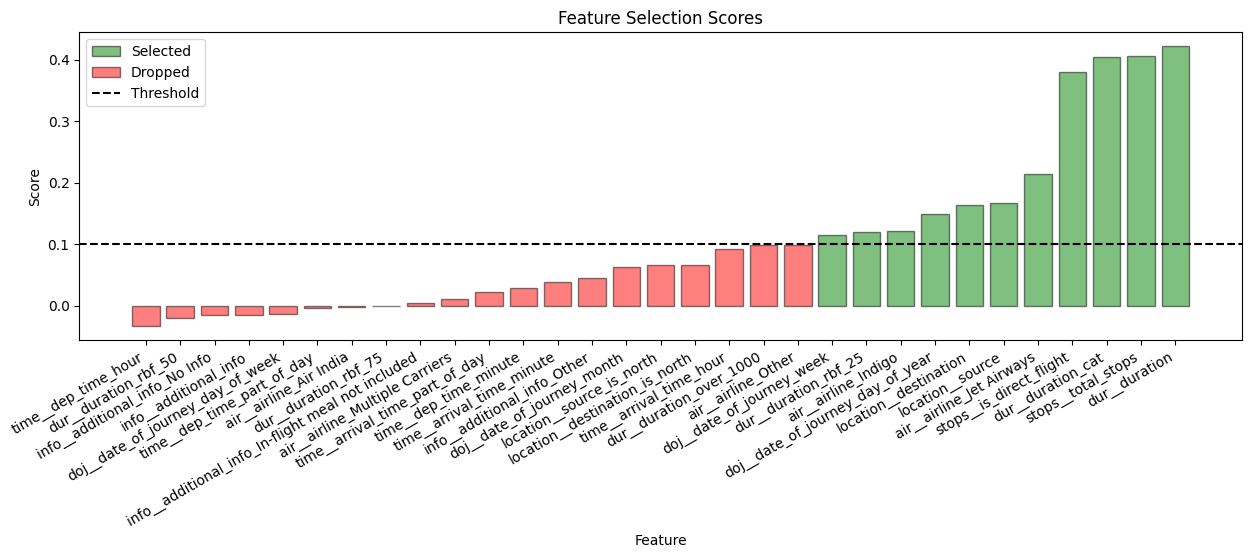

In [54]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()